title: ATM Locator Usage Research
<br>
date: 2021-09-07
<br>
region: US
<br>
author: Henry Xu
<br>
tags: ATM, cash, withdrawal, ATM locator, ATM map, map, feature, product discovery
<br>
summary: This research explores whether users used ATM locator map to help them find an ATM before they conducted an ATM transaction. We also exmaine whether there are simple demographic differences between users who uses ATM locator and users who don't.

## ATM Locator Usage Research

#### Findings about ATM locator usage:

Querying into database shows that out of 22,257 users who had an ATM transaction in Q1 2021,
<br>
> - 3413 users (15%) had the ATM transaction within 24 hours (from 0 - 24h) of viewing the ATM locator,
<br>
> - 3809 users (17%) had the ATM transaction within 48 hours (from 0 - 48h) of viewing the ATM locator,
<br>
> - 4905 users (22%) had the ATM transaction within 7 days(from 0 - 7 days) of viewing the ATM locator.
<br>
<br>
This analysis is based on ATM transactions in Q1 2021 and assumes that users who had the ATM transaction within 48 hours of viewing the ATM locator as using the feature.
<br>
Therefore 17% of users who had an ATM transaction actually used ATM locator prior to the transaction.

#### Findings about user demographics

> - There is no clear distinction between users who use and don't use ATM locator in terms of age, occupation or state they are from. 
> - The average age for all ATM users is 35-36, and most centered around age 30. 
> - Top 3 occupation for all ATM users are food, sales and construction. (The top one is actually 'Other' which is comprised of all types of occupations)
> - Top 4 places for ATM users are FL, TX, CA, NY

In [ ]:
# pip install matplotlib

In [ ]:
# pip install seaborn

In [ ]:
# pip install plotly

In [4]:
## import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [6]:
## Importing data
## This pulls in all the users who uses an ATM machine within 48 hours of viewing the ATM locator

from datalib import database
from utils import setup

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")

with db.engine.begin() as conn:
    use_locator = db.df_from_sql(
        """
        with atm_txn as (
        select
                du.shadow_user_id,
                ft.completed_tstamp,
                du.user_id,
                du.occupation,
                du.birth_date
            from dbt.f_transactions ft 
            inner join dbt.dim_users du 
                on ft.user_id = du.user_id
                and du.kyc_first_completed <= '2021-03-31'
                and ft.type = 'ATM'
                and ft.completed_tstamp between '2021-01-01' and '2021-04-01'
        ),
        txn_window as (
            select distinct 
                    at.user_id,
                    at.occupation,
                    at.birth_date
            from etl_reporting.ksp_event_core kec 
            inner join etl_reporting.ksp_event_types ket 
                on kec.event_type = ket.event_type 
            inner join etl_reporting.ksp_ip_geo kig 
                on kec.event_id = kig.event_id 
                and kig.country = 'US'
                and ket.se_action = 'atm_map_open'
                and kec.collector_tstamp between '2021-01-01' and '2021-04-02'
            inner join atm_txn as at
                on at.shadow_user_id = kec.user_id 
                and at.completed_tstamp >= kec.collector_tstamp
                and datediff(hour,  kec.collector_tstamp::timestamp, at.completed_tstamp::timestamp) <= 48 -- adjust the time here for different window
        ),
        latest_date as (
            select 
                tw.user_id,
                tw.occupation,
                tw.birth_date,
                da.city,
                da.state,
                da.country,
                row_number() over(partition by da.user_id order by updated desc) as date_rnk
            from txn_window as tw
            inner join dbt.dim_address da 
                on da.user_id = tw.user_id
        )
        select 
                ld.user_id,
                ld.occupation,
                ld.birth_date,
                ld.city,
                ld.state,
                ld.country
        from latest_date as ld
        where date_rnk = 1                   
        """,
        connection=conn,
    )

In [7]:
## This pulls in all users who had an ATM transaction

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")


with db.engine.begin() as conn:
    all_atm = db.df_from_sql(
        """
        with kyc_completed as (
            select distinct 
                        du.user_id,
                        du.occupation,
                        du.birth_date
            from dbt.f_transactions ft 
            inner join dbt.dim_users du 
                on du.user_id = ft.user_id
                and kyc_first_completed <= '2021-03-31'
            where ft.type = 'ATM'
                and ft.completed_tstamp between '2021-01-01' and '2021-04-01'
        ),
        rank_address as (
            select 
                kyc.user_id,
                kyc.occupation,
                kyc.birth_date,
                da.city,
                da.state,
                da.country,
                row_number() over(partition by da.user_id order by updated desc) as date_rnk
            from kyc_completed as kyc
            inner join dbt.dim_address da 
                on da.user_id = kyc.user_id
        )
        select
            ra.user_id,
            ra.occupation,
            ra.birth_date,
            ra.city,
            ra.state,
            ra.country
        from rank_address as ra 
        where date_rnk = 1    
        """,
        connection=conn,
    )

#### Analyze users who uses locator

##### Age of ATM locator users 

In [8]:
use_locator["birth_date"] = use_locator["birth_date"].astype("datetime64")

In [9]:
# get the age for the users

from datetime import date as dt

td = dt.today().year
use_locator["age"] = (
    np.repeat(td, len(use_locator["birth_date"])) - use_locator["birth_date"].dt.year
)

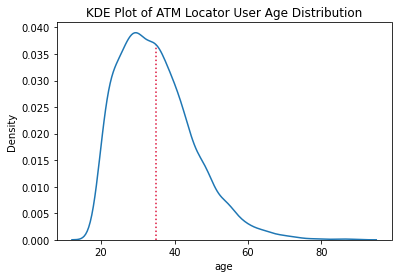

In [10]:
## look at age distribution for the users who uses ATM locator

mean_age = use_locator["age"].mean()

ax = sns.kdeplot(use_locator["age"])
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_age, xs, ys)
ax.vlines(mean_age, 0, height, color="crimson", ls=":")

plt.title("KDE Plot of ATM Locator User Age Distribution")
plt.show()

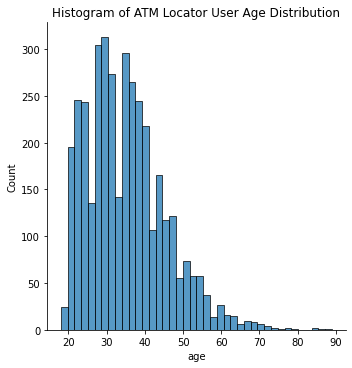

In [11]:
sns.displot(use_locator["age"])
plt.title("Histogram of ATM Locator User Age Distribution")
plt.show()

Findings:
> - the average age is 35
> - the most dense group of users who uses ATM locator is around age of 30

##### Occupation of ATM locator users

In [12]:
## look at user occupation of the users who uses ATM locator

use_locator["occupation"].value_counts().iloc[:10]

OTHER                                    601
FOOD                                     377
CONSTRUCTION                             363
SALES                                    363
HEALTHCARE                               287
MANUFACTURING                            183
US_STUDENT                               182
TRANSPORTATION_LOGISTICS                 163
OFFICE_ADMINISTRATIVE                    158
JOURNALISM_MEDIA_SPORTS_ENTERTAINMENT    119
Name: occupation, dtype: int64

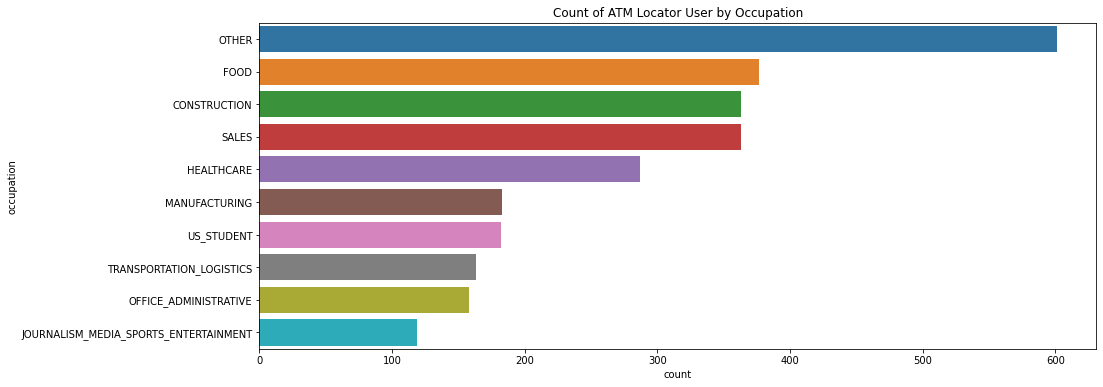

In [13]:
plt.figure(figsize=(15, 6))
sns.countplot(
    y=use_locator["occupation"],
    order=use_locator["occupation"].value_counts().iloc[:10].index,
)
plt.title("Count of ATM Locator User by Occupation")
plt.show()

Findings: Top 3 are food, sales and construction

##### Resident state of ATM locator users 

In [14]:
state_cnt = pd.DataFrame(use_locator["state"].value_counts().iloc[:10].reset_index())
state_cnt.rename(columns={"index": "state", "state": "user_cnt"}, inplace=True)
state_cnt

,state,user_cnt
0,FL,413
1,TX,361
2,CA,319
3,NY,275
4,GA,217
5,OH,212
6,IL,168
7,PA,128
8,TN,97
9,NC,91


In [16]:
## Plot on the plotly map
## This is commented out as HTML generator script with beautiful soup cannot output plotly map at the moment

# import plotly.graph_objects as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [17]:
# set up so that the figures show up in the notebook

# init_notebook_mode(connected=True)

In [18]:
## plotly map


# fig = go.Figure(data = go.Choropleth(
#                 locations = state_cnt['state'],
#                 z = state_cnt['user_cnt'].astype(float),
#                 locationmode = 'USA-states',
#                 colorscale = ['#C89D58', '#B35D5B', '#36A18B'],
#                 autocolorscale = False,
#                 marker_line_color = 'white', # line markers between states
#                 colorbar_title = "User Count"
# ))


# fig.update_layout(
#     title_text = '2021 Q1 Users Who Use AMT Locator by State',
#     geo = dict(
#         scope = 'usa',
#         projection = go.layout.geo.Projection(type = 'albers usa'),
#         showlakes = False, # lakes
# ))


# fig.show()

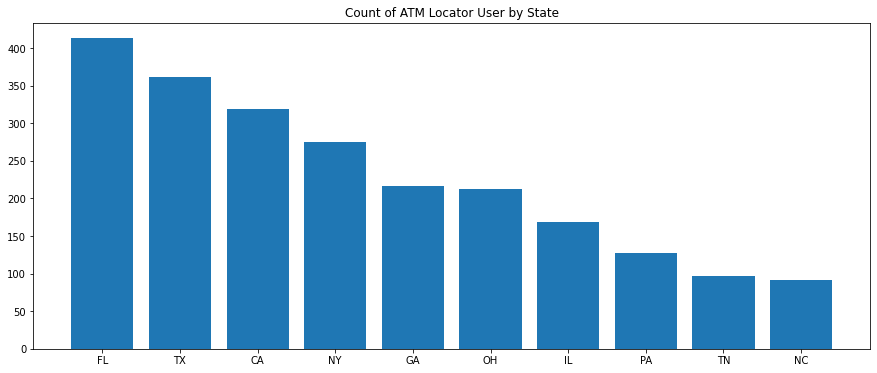

In [20]:
plt.figure(figsize=(15, 6))
plt.bar(state_cnt["state"], state_cnt["user_cnt"])
plt.title("Count of ATM Locator User by State")
plt.show()

Findings: Top 3 are FL, TX, CA

#### Analyze users had an ATM transaction without viewing the ATM locator 

##### Age of all ATM users

In [21]:
mask = ~all_atm["user_id"].isin(use_locator["user_id"])

not_use_locator = all_atm.loc[mask, :]

In [22]:
pd.options.mode.chained_assignment = None

not_use_locator["birth_date"] = not_use_locator["birth_date"].astype("datetime64")

In [23]:
# get the age for the users

from datetime import date as dt

td = dt.today().year
not_use_locator["age"] = (
    np.repeat(td, len(not_use_locator["birth_date"]))
    - not_use_locator["birth_date"].dt.year
)

In [24]:
mean_age = not_use_locator["age"].mean()

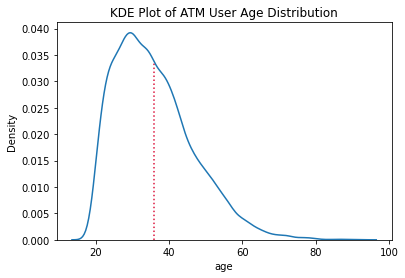

In [25]:
## look at age distribution for the users who don't use ATM locator

mean_age = not_use_locator["age"].mean()

ax = sns.kdeplot(not_use_locator["age"])
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_age, xs, ys)
ax.vlines(mean_age, 0, height, color="crimson", ls=":")

plt.title("KDE Plot of ATM User Age Distribution")
plt.show()

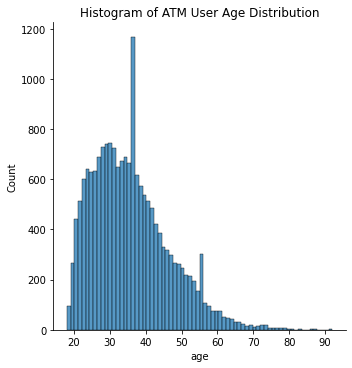

In [26]:
sns.displot(not_use_locator["age"])
plt.title("Histogram of ATM User Age Distribution")
plt.show()

Findings:
> - the average age is 36
> - the most dense group of users who uses ATM locator is around age of 30

##### Occupation of all ATM users

Text(0.5, 1.0, 'Count of All ATM User by Occupation')

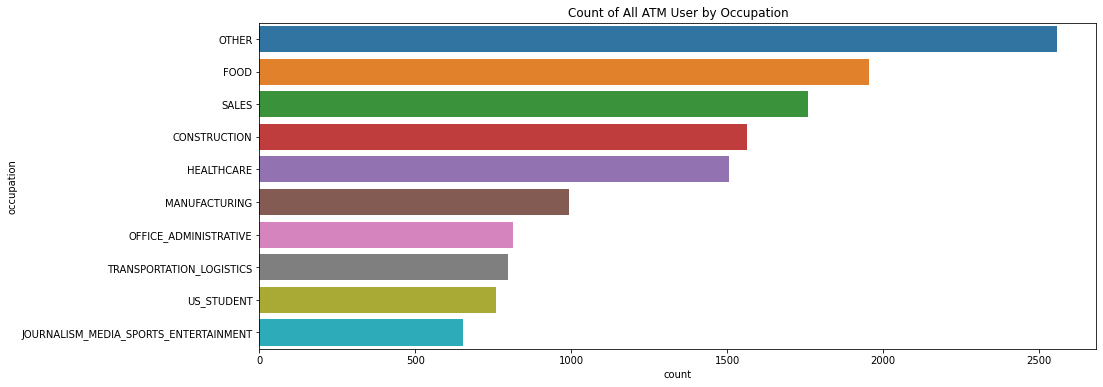

In [27]:
## look at user occupation of the users who uses ATM locator

plt.figure(figsize=(15, 6))
sns.countplot(
    y=not_use_locator["occupation"],
    order=not_use_locator["occupation"].value_counts().iloc[:10].index,
)
plt.title("Count of All ATM User by Occupation")

Findings: Top 3 are food, sales and construction

##### Resident state of all ATM users

In [28]:
state_cnt = pd.DataFrame(
    not_use_locator["state"].value_counts().iloc[:10].reset_index()
)
state_cnt.rename(columns={"index": "state", "state": "user_cnt"}, inplace=True)
state_cnt

,state,user_cnt
0,TX,1935
1,FL,1815
2,NY,1434
3,CA,1414
4,GA,1271
5,IL,747
6,OH,705
7,NC,548
8,MI,502
9,PA,473


In [29]:
## plotly map
## This is commented out as HTML generator script with beautiful soup cannot output plotly map at the moment

# fig = go.Figure(data = go.Choropleth(
#                 locations = state_cnt['state'],
#                 z = state_cnt['user_cnt'].astype(float),
#                 locationmode = 'USA-states',
#                 colorscale = ['#C89D58', '#B35D5B', '#36A18B'],
#                 autocolorscale = False,
#                 marker_line_color = 'white', # line markers between states
#                 colorbar_title = "User Count"
# ))


# fig.update_layout(
#     title_text = '2021 Q1 Users Who Use AMT Locator by State',
#     geo = dict(
#         scope = 'usa',
#         projection = go.layout.geo.Projection(type = 'albers usa'),
#         showlakes = False, # lakes
# ))


# fig.show()

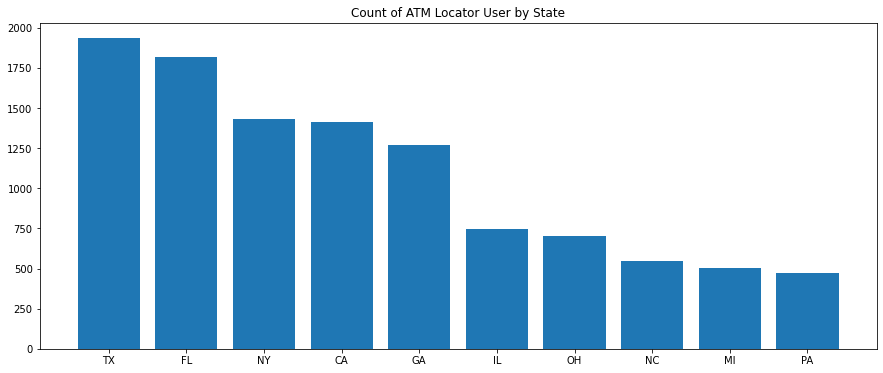

In [30]:
plt.figure(figsize=(15, 6))
plt.bar(state_cnt["state"], state_cnt["user_cnt"])
plt.title("Count of ATM Locator User by State")
plt.show()

Findings: Top 3 are TX, FL, NY